In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shl-intern-hiring-assessment/dataset/sample_submission.csv
/kaggle/input/shl-intern-hiring-assessment/dataset/train.csv
/kaggle/input/shl-intern-hiring-assessment/dataset/test.csv
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_885.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_698.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_1176.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_1215.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_66.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_386.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_1026.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_330.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_72.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_858.wav
/kaggle/input/shl-intern-hiring-ass

In [2]:
import os

print(os.listdir('/kaggle/input/'))
print(os.listdir('/kaggle/input/shl-intern-hiring-assessment'))


['shl-intern-hiring-assessment']
['dataset']


In [3]:
import pandas as pd

# Correct paths with the nested 'dataset' folder
base_path = '/kaggle/input/shl-intern-hiring-assessment/dataset'

train_df = pd.read_csv(f'{base_path}/train.csv')
test_df = pd.read_csv(f'{base_path}/test.csv')
sample_submission = pd.read_csv(f'{base_path}/sample_submission.csv')

# Show the first few rows
print("Train shape:", train_df.shape)
train_df.head()


Train shape: (444, 2)


,filename,label
0,audio_1261.wav,1.0
1,audio_942.wav,1.5
2,audio_1110.wav,1.5
3,audio_1024.wav,1.5
4,audio_538.wav,2.0


In [4]:
import os

base_path = "/kaggle/input/shl-intern-hiring-assessment/dataset"

# List all items inside the dataset folder
for item in os.listdir(base_path):
    item_path = os.path.join(base_path, item)
    print(f"{item} --> {'Folder' if os.path.isdir(item_path) else 'File'}")

sample_submission.csv --> File
audios_test --> Folder
train.csv --> File
test.csv --> File
audios_train --> Folder


Loaded 'audio_1261.wav' with duration 60.07 seconds


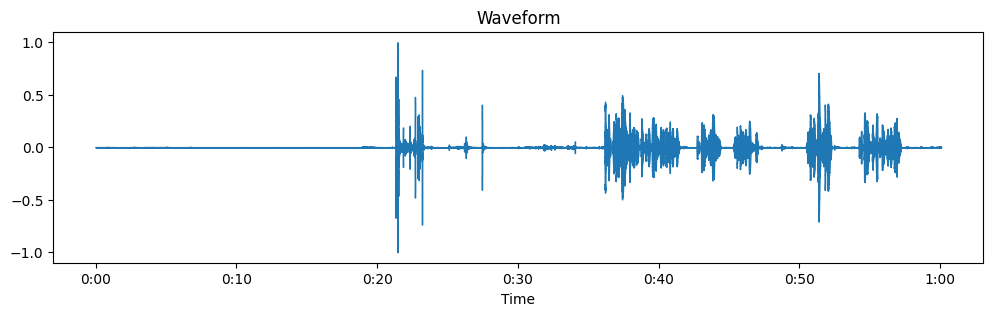

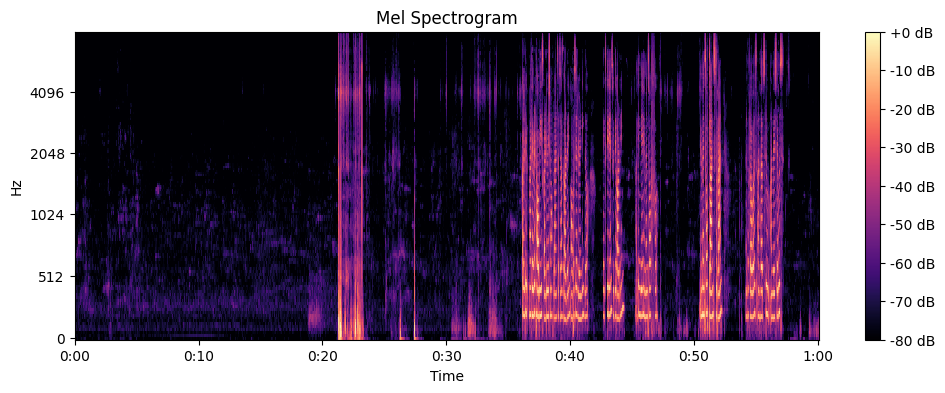

In [5]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Base audio path
audio_base = "/kaggle/input/shl-intern-hiring-assessment/dataset/audios_train"

# Pick one file from the train dataframe
file_name = train_df.iloc[0]['filename']
audio_path = f"{audio_base}/{file_name}"

# Load audio
y, sr = librosa.load(audio_path, sr=None)
print(f"Loaded '{file_name}' with duration {len(y)/sr:.2f} seconds")

# Plot waveform
plt.figure(figsize=(12, 3))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.show()

# Plot Mel Spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()

In [6]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    
    # Extract features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    zcr = librosa.feature.zero_crossing_rate(y)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    rms = librosa.feature.rms(y=y)
    
    # Aggregate (mean) over time axis
    features = {
        'mfcc_mean': mfccs.mean(axis=1),
        'zcr_mean': zcr.mean(),
        'centroid_mean': centroid.mean(),
        'rms_mean': rms.mean(),
    }
    
    # Flatten MFCC into separate columns
    for i in range(13):
        features[f'mfcc_{i+1}'] = features['mfcc_mean'][i]
    
    # Remove the list entry now
    del features['mfcc_mean']
    
    return features

In [7]:
from tqdm import tqdm

features_list = []

for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
    file_name = row['filename']
    label = row['label']
    file_path = f"/kaggle/input/shl-intern-hiring-assessment/dataset/audios_train/{file_name}"
    
    features = extract_features(file_path)
    features['label'] = label
    features_list.append(features)

# Convert to DataFrame
features_df = pd.DataFrame(features_list)
print("Features shape:", features_df.shape)
features_df.head()

100%|██████████| 444/444 [02:47<00:00,  2.65it/s]

Features shape: (444, 17)


,zcr_mean,centroid_mean,rms_mean,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,label
0,0.143139,1812.681453,0.015064,-485.992737,50.111820,8.837244,9.500427,1.973222,2.533967,-6.811783,1.587861,-4.828947,-3.566349,-2.680598,-2.683721,-2.376489,1.0
1,0.105385,1962.232377,0.037655,-418.862366,24.498125,0.983082,3.577540,-11.690801,-2.484139,-9.580399,-0.941148,-7.578836,1.941515,-4.787622,-2.934152,-6.141343,1.5
2,0.132682,2126.143258,0.021168,-468.621979,55.773441,-6.867956,12.415868,2.657126,-3.901442,-1.949762,-3.627632,-3.994594,0.676666,-5.172700,-3.183967,-2.695612,1.5
3,0.094663,1296.033816,0.041441,-395.975739,83.706886,-9.338621,22.242302,2.223831,-4.640110,0.991509,-5.542060,-6.253079,-0.231806,-7.615921,-4.440738,-7.586988,1.5
4,0.136809,1601.473150,0.043016,-300.150665,104.442307,-19.612244,7.221632,-6.562626,-9.136395,-10.110367,-10.232144,-5.131830,-7.595556,-0.803845,-4.498086,-4.217596,2.0


In [8]:
#pre-processing done we move on to the next part
#using a regression model 
from sklearn.model_selection import train_test_split

X = features_df.drop(columns=['label'])
y = features_df['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on validation
y_pred = model.predict(X_val)

# Evaluate
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)

print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation R² Score: {r2:.4f}")


Validation RMSE: 1.0460
Validation R² Score: 0.1974


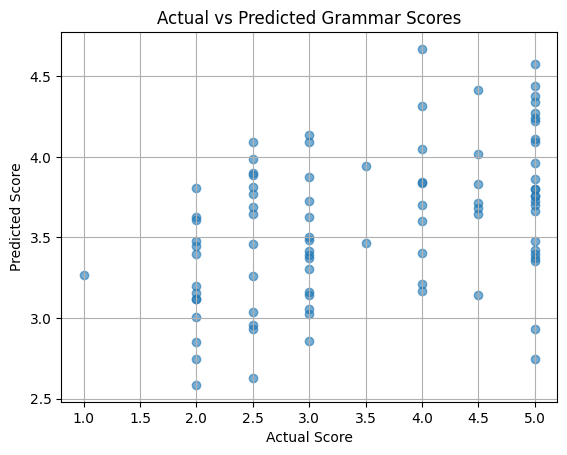

In [10]:
import matplotlib.pyplot as plt

plt.scatter(y_val, y_pred, alpha=0.6)
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Actual vs Predicted Grammar Scores")
plt.grid(True)
plt.show()

In [11]:
#extracting features from test audio
test_features_list = []

for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    file_name = row['filename']
    file_path = f"/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/{file_name}"
    
    try:
        features = extract_features(file_path)
        features['filename'] = file_name
        test_features_list.append(features)
    except:
        print("Error in:", file_name)

100%|██████████| 195/195 [01:02<00:00,  3.10it/s]


In [12]:
#testing features
test_features_df = pd.DataFrame(test_features_list)
print("Test features shape:", test_features_df.shape)
test_features_df.head()

Test features shape: (195, 17)


,zcr_mean,centroid_mean,rms_mean,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,filename
0,0.150859,1652.834782,0.031372,-340.821472,87.854080,-27.584362,20.225647,9.789281,-6.006240,-1.812913,-4.854423,-6.230354,-9.591330,-7.490045,-0.094280,1.480482,audio_706.wav
1,0.150618,1611.261856,0.033988,-320.663483,99.582268,-35.042381,20.576435,6.647259,-4.562370,-1.034688,-1.351265,-4.737388,-8.951274,-7.306235,-0.265117,0.919813,audio_800.wav
2,0.136084,1305.127792,0.054290,-384.169739,140.472260,15.962435,14.047473,1.825912,-29.573217,-11.135431,-0.298703,-19.445065,-9.586742,1.516608,-7.481087,-8.768907,audio_68.wav
3,0.210088,2162.147753,0.050933,-353.733887,68.909996,-21.333244,21.156925,-9.502240,3.276733,-17.961323,-21.368092,1.456813,-5.987282,7.406195,-12.485026,0.366195,audio_1267.wav
4,0.077122,1271.088190,0.040125,-381.192749,129.610123,12.445641,19.765879,11.896509,2.893462,-4.999232,-1.013147,-11.823614,-6.507668,-0.879629,1.136893,1.312673,audio_683.wav


In [13]:
#prediction using trained model
# Drop filename column for prediction
X_test = test_features_df.drop(columns=['filename'])

# Predict grammar scores
test_preds = model.predict(X_test)

In [14]:
#now finally creating a submission file 
submission = pd.DataFrame({
    'filename': test_features_df['filename'],
    'label': test_preds
})

# Save submission
submission.to_csv('submission.csv', index=False)
submission.head()

,filename,label
0,audio_706.wav,2.92
1,audio_800.wav,2.81
2,audio_68.wav,3.80
3,audio_1267.wav,3.90
4,audio_683.wav,2.96
